In [11]:
import random
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import cross_val_score
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('gutenberg')
nltk.download('stopwords')

random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\harka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\harka\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Creating dataset

In [12]:
class GutenbergPartitioner:
    def __init__(self):
        # Select books from a specific genre
        self.all_books = gutenberg.fileids()
        self.selected_books = random.sample(self.all_books, 6)  # Choose 6 books randomly
        self.book_data = [(book, gutenberg.raw(book)) for book in self.selected_books]

    def get_author(self, book_text):
        # Extract author information from book text
        # This is a simplistic approach and may not work for all books
        lines = book_text.split('\n')
        for line in lines:
            if 'by' in line.lower():
                author_index = line.lower().index('by')
                author = line[author_index + 2:].strip()
                # Remove any year like 1909] from author's name
                author = ''.join([i for i in author if not i.isdigit() and i != ']'])
                return author
        return 'Unknown Author'

    def split_into_partitions(self, num_partitions=200, partition_size=100):
        partitions = []
        for book, data in self.book_data:
            author = self.get_author(data)
            words = word_tokenize(data)
            for _ in range(num_partitions):
                start_index = random.randint(0, len(words) - partition_size)
                partition = ' '.join(words[start_index:start_index + partition_size])
                partitions.append((book, author, partition))

        # Shuffle the order of partitions
        random.shuffle(partitions)

        # Label the partitions with alphabetical labels
        labels = {book: chr(ord('a') + i) for i, book in enumerate(self.selected_books)}

        # Add the labels to the partitions
        labeled_partitions = [(labels[book], author, partition) for book, author, partition in partitions]
        return labeled_partitions

    def save_to_csv(self, labeled_partitions, output_filename='random_partitions.csv'):
        # Serialize the data using Pandas
        df = pd.DataFrame(labeled_partitions, columns=['Book', 'Author', 'Partition'])
        df.to_csv(output_filename, index=False)

#### Data Processing 
- Removing stopwords
- Tokenization of the data
- Steming and Lemetization of words 
- Traning and Evaluation of the model

In [13]:
def preprocess_text(text):
    # Tokenize, remove stopwords, and non-alphabetic characters
    tokens = nltk.word_tokenize(text)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords]

    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(token)) for token in stemmed_tokens]

    return ' '.join(lemmatized_tokens)

def get_wordnet_pos(word):
    # Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def train_model(classifier, vectorizer):
    partitioner = GutenbergPartitioner()
    labeled_partitions = partitioner.split_into_partitions()
    partitioner.save_to_csv(labeled_partitions)

    # Load labeled partitions from CSV
    df = pd.read_csv('random_partitions.csv')

    # Preprocess the data
    df['Processed_Partition'] = df['Partition'].apply(preprocess_text)

    # Feature extraction using TF-IDF
    features = vectorizer.fit_transform(df['Processed_Partition']).toarray()
    #print(features)
    labels = df['Book']
    authors = df['Author']  # Include authors as a separate column

    # Train a machine learning model
    classifier.fit(features, authors)  # Change labels to authors

    return classifier, vectorizer, authors

def evaluate_model(classifier, vectorizer, authors):
    # Load labeled partitions from CSV
    df = pd.read_csv('random_partitions.csv')

    # Preprocess the data
    df['Processed_Partition'] = df['Partition'].apply(preprocess_text)

    # Feature extraction using TF-IDF
    features = vectorizer.transform(df['Processed_Partition']).toarray()
    labels = df['Book']

    # Perform k-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = authors[train_index], authors[test_index]  # Change labels to authors

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        roc_auc_scores.append(roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr'))

    
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


    # Calculate bias and variance
    bias = 1 - np.mean(accuracy_scores)
    variance = np.var(accuracy_scores)

    return {
        'Bias': bias,
        'Variance': variance,
        'Accuracy': np.mean(accuracy_scores),
        'Precision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1-score': np.mean(f1_scores),
        'ROC-AUC': np.mean(roc_auc_scores)
    }


### Printing the results of different models 
- Bias and variance plot 
- Acurracy and prediction results 
- Word cloud per fold 

In [14]:
def print_results_subset(df, test_labels, predictions, authors, start_idx, end_idx):
    print(f"\nSubset of results:")
    print("{:<10} {:<30} {:<30} {:<30}".format("Book", "True Author", "Predicted Book", "Predicted Author"))
    print("="*100)
    for i in range(start_idx, end_idx):
        book_label = df.loc[i, 'Book']
        true_author = authors[i]  # Extract true author from the authors list
        predicted_book = test_labels[i]  # Extract predicted book from the test_labels list
        predicted_author = predictions[i]
        print("{:<10} {:<30} {:<30} {:<30}".format(book_label, true_author, predicted_book, predicted_author))

def plot_bias_variance(classifiers, results):
    classifier_names = list(classifiers.keys())
    bias_values = [result['Bias'] for result in results.values()]
    variance_values = [result['Variance'] for result in results.values()]

    plt.figure(figsize=(10, 5))
    plt.plot(classifier_names, bias_values, marker='o', label='Bias')
    plt.plot(classifier_names, variance_values, marker='o', label='Variance')
    plt.xlabel('Classifier')
    plt.ylabel('Bias/Variance')
    plt.title('Bias and Variance of Classifiers')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Evaluating Naive Bayes...


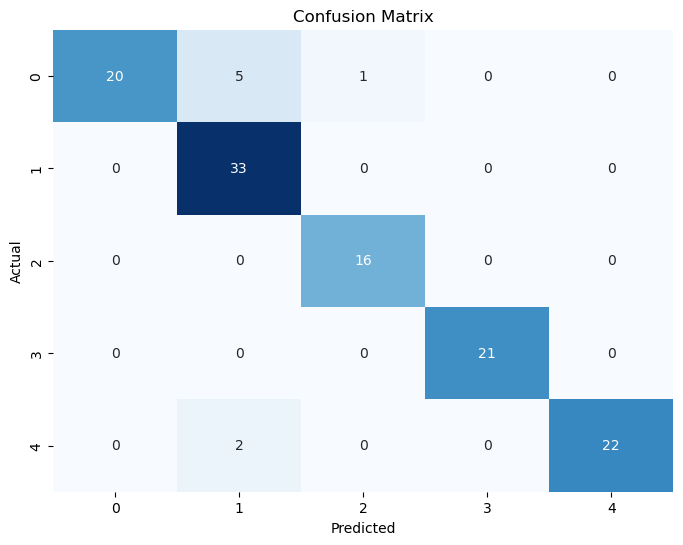

Results for Naive Bayes:
Bias: 0.05833333333333324
Variance: 0.000152777777777778
Accuracy: 0.9416666666666668
Precision: 0.9471483036342333
Recall: 0.9416666666666668
F1-score: 0.9406009390808523
ROC-AUC: 0.9971655302180473


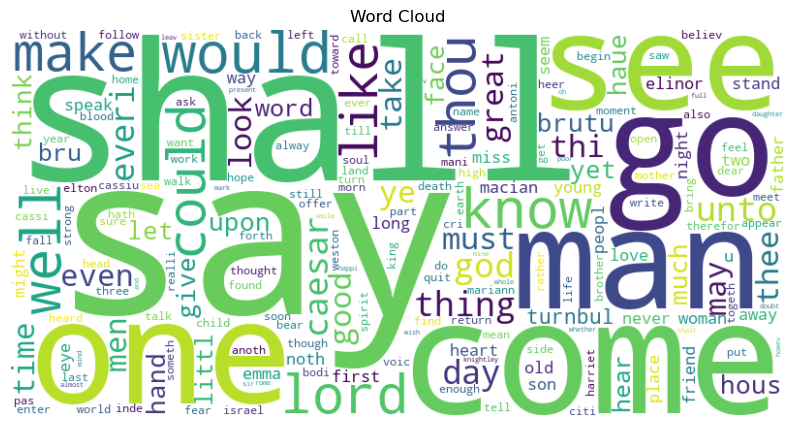


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
e          William Shakespeare            e                              William Shakespeare           
d          Walt Whitman                   d                              Walt Whitman                  
a          sevens, the male               a                              sevens, the male              
f          Jane Austen                    f                              Jane Austen                   
e          William Shakespeare            e                              William Shakespeare           
a          sevens, the male               a                              sevens, the male              
c          G.K. Chesterton                c                              Jane Austen                   
b          Jane Austen                    b                              Jane Austen                   
a          sevens, the male               a 

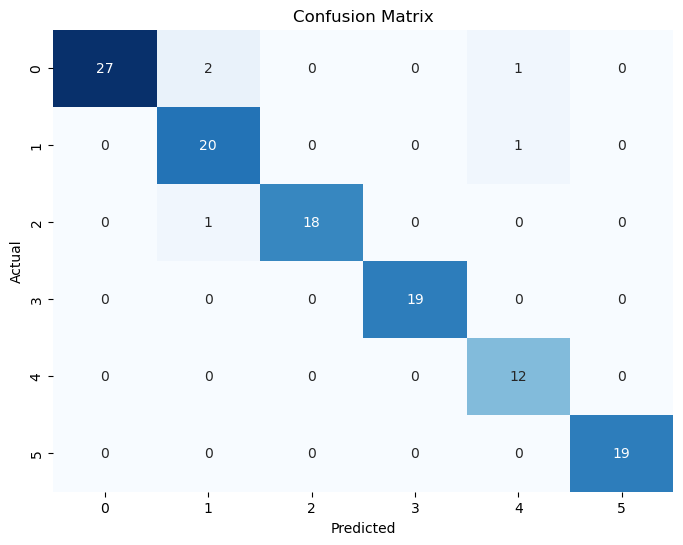

Results for Logistic Regression:
Bias: 0.054166666666666585
Variance: 0.00043402777777777824
Accuracy: 0.9458333333333334
Precision: 0.9501056713685815
Recall: 0.9458333333333334
F1-score: 0.9459782288440254
ROC-AUC: 0.9944319530137617


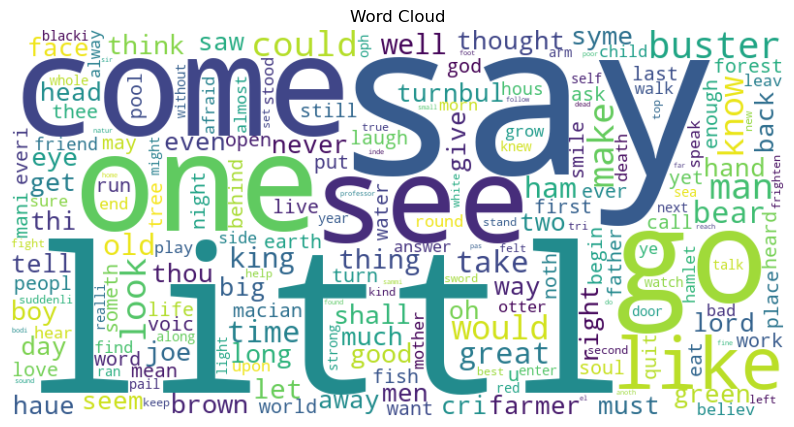


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
b          G. K. Chesterton               b                              G. K. Chesterton              
b          G. K. Chesterton               b                              G. K. Chesterton              
c          William Shakespeare            c                              William Shakespeare           
a          Walt Whitman                   a                              Walt Whitman                  
f          Sara Cone Bryant               f                              Sara Cone Bryant              
e          Thornton W. Burgess            e                              Thornton W. Burgess           
a          Walt Whitman                   a                              Walt Whitman                  
b          G. K. Chesterton               b                              G. K. Chesterton              
d          G.K. Chesterton                d 

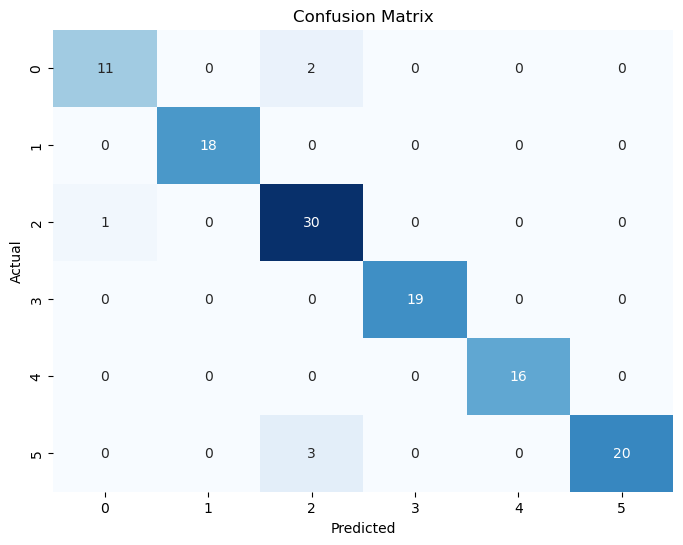

Results for Support Vector Machine:
Bias: 0.04333333333333356
Variance: 0.00044166666666666643
Accuracy: 0.9566666666666664
Precision: 0.9606026861386558
Recall: 0.9566666666666664
F1-score: 0.9570997227623443
ROC-AUC: 0.9975932974297175


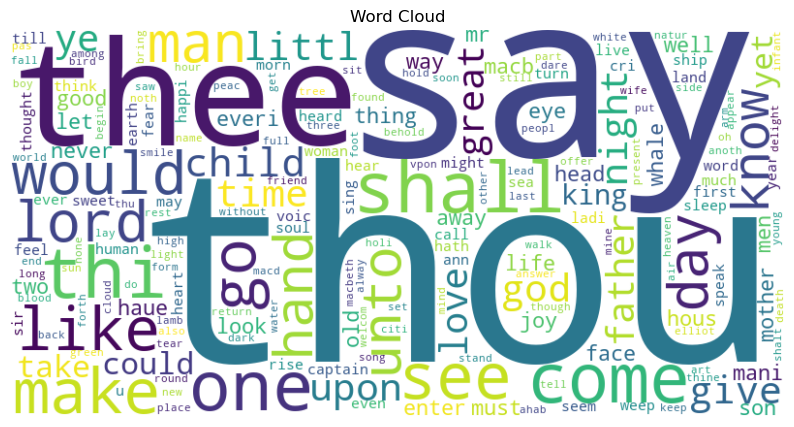


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
a          William Blake                  a                              William Blake                 
c          William Shakespeare            c                              William Shakespeare           
f          Dick by Herman Melville        f                              Dick by Herman Melville       
a          William Blake                  a                              William Blake                 
a          William Blake                  a                              William Blake                 
c          William Shakespeare            c                              William Shakespeare           
f          Dick by Herman Melville        f                              Dick by Herman Melville       
f          Dick by Herman Melville        f                              Dick by Herman Melville       
d          sevens, the male               d 

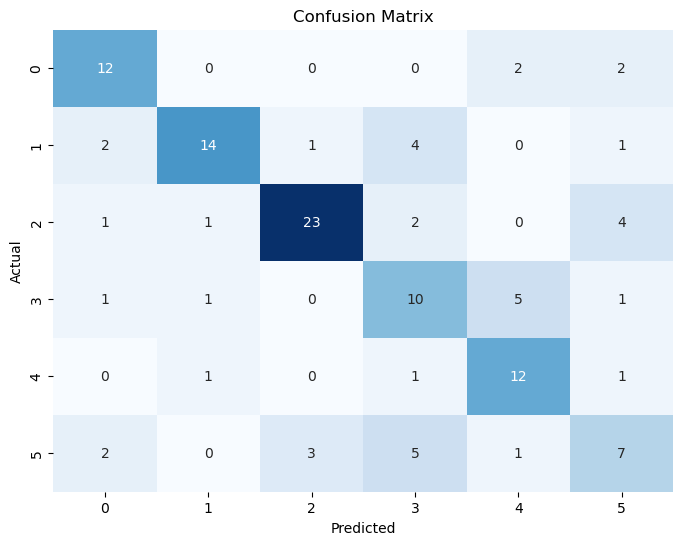

Results for Decision Tree:
Bias: 0.41166666666666674
Variance: 0.0022388888888888884
Accuracy: 0.5883333333333333
Precision: 0.6055504959760096
Recall: 0.5883333333333333
F1-score: 0.5888069262952988
ROC-AUC: 0.7553537097707959


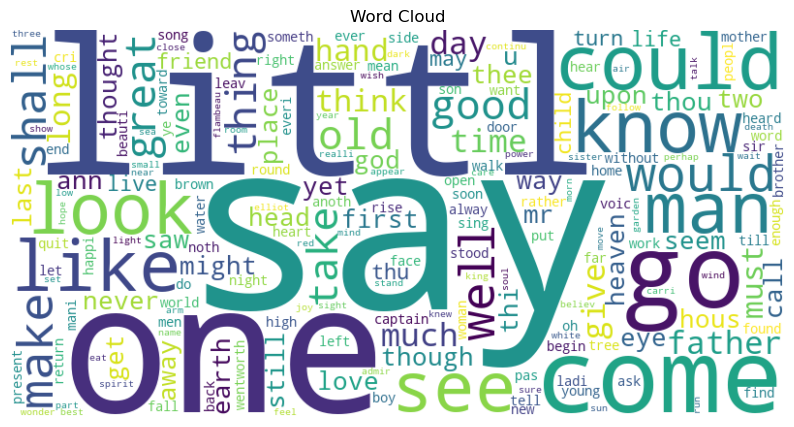


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
b          Walt Whitman                   b                              Walt Whitman                  
a          G. K. Chesterton               a                              G. K. Chesterton              
b          Walt Whitman                   b                              Walt Whitman                  
f          Jane Austen                    f                              Maria Edgeworth               
d          Maria Edgeworth                d                              Walt Whitman                  
e          Sara Cone Bryant               e                              Sara Cone Bryant              
c          John Milton                    c                              John Milton                   
b          Walt Whitman                   b                              Walt Whitman                  
c          John Milton                    c 

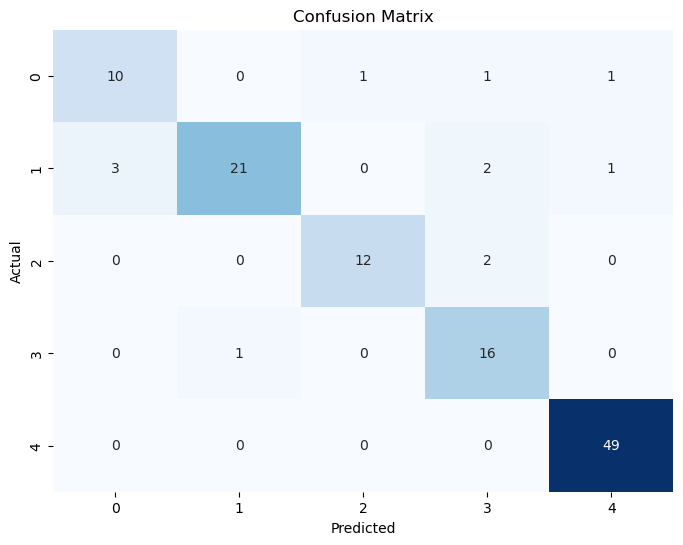

Results for Random Forest:
Bias: 0.09416666666666662
Variance: 0.0008062500000000003
Accuracy: 0.9058333333333334
Precision: 0.9098504643896212
Recall: 0.9058333333333334
F1-score: 0.9050774331169086
ROC-AUC: 0.9877991787980873


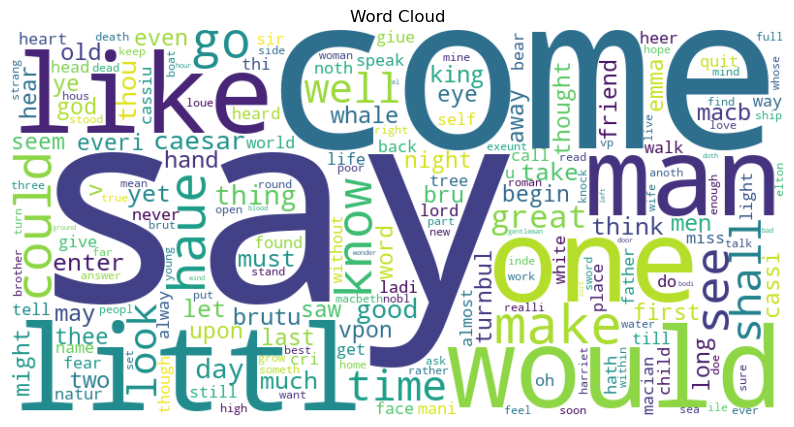


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
e          Dick by Herman Melville        e                              Dick by Herman Melville       
d          William Shakespeare            d                              William Shakespeare           
d          William Shakespeare            d                              William Shakespeare           
f          G.K. Chesterton                f                              G.K. Chesterton               
c          William Shakespeare            c                              William Shakespeare           
f          G.K. Chesterton                f                              G.K. Chesterton               
e          Dick by Herman Melville        e                              Dick by Herman Melville       
c          William Shakespeare            c                              William Shakespeare           
e          Dick by Herman Melville        e 

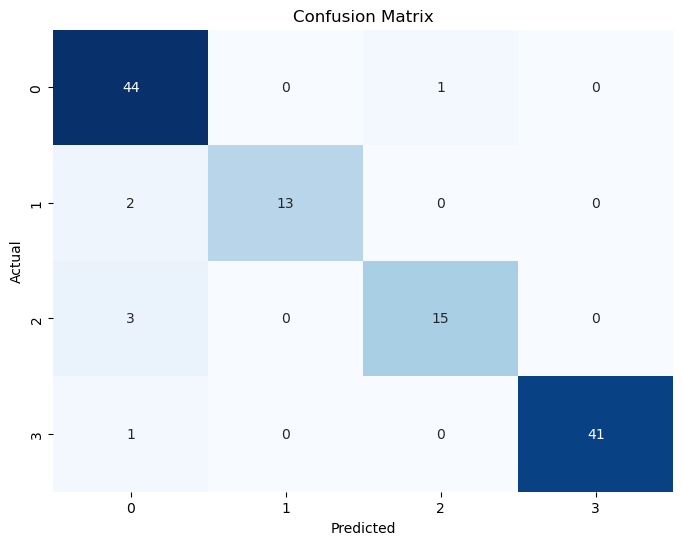

Results for Gradient Boosting:
Bias: 0.09250000000000003
Variance: 0.0004368055555555552
Accuracy: 0.9075
Precision: 0.917588429429107
Recall: 0.9075
F1-score: 0.9072289248269938
ROC-AUC: 0.9853018529736273


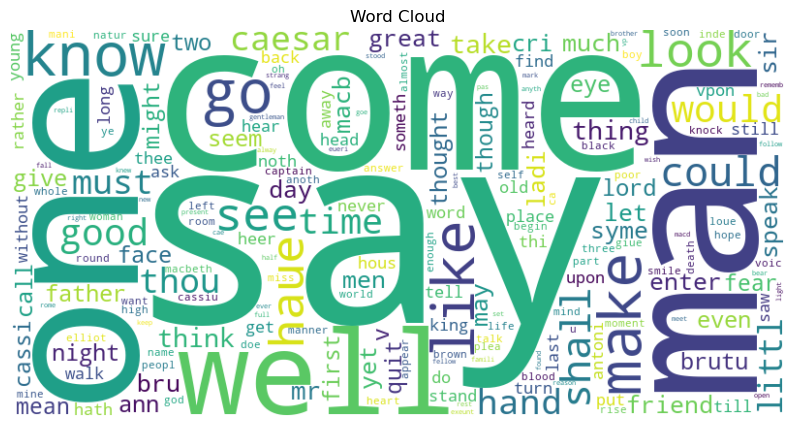


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
f          William Shakespeare            f                              William Shakespeare           
a          Maria Edgeworth                a                              Maria Edgeworth               
d          Jane Austen                    d                              Jane Austen                   
a          Maria Edgeworth                a                              Maria Edgeworth               
f          William Shakespeare            f                              William Shakespeare           
c          G. K. Chesterton               c                              G. K. Chesterton              
f          William Shakespeare            f                              William Shakespeare           
b          G. K. Chesterton               b                              G. K. Chesterton              
e          William Shakespeare            e 

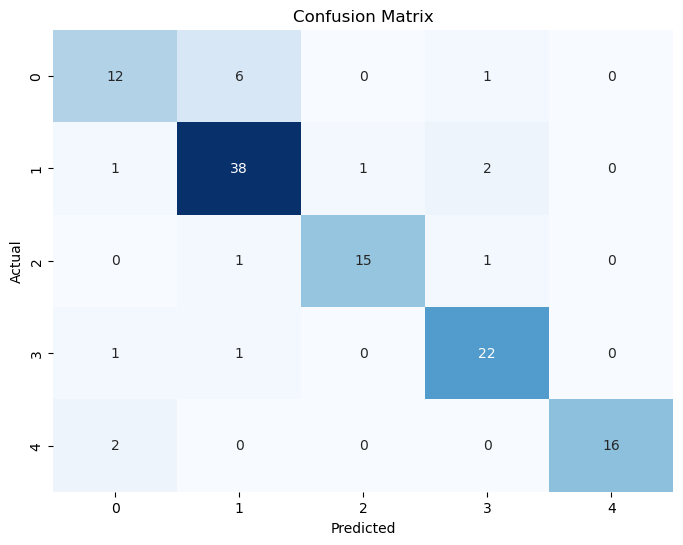

Results for KNN:
Bias: 0.10250000000000004
Variance: 0.0007229166666666679
Accuracy: 0.8975
Precision: 0.9011266191582885
Recall: 0.8975
F1-score: 0.8973114802722313
ROC-AUC: 0.9776782189606934


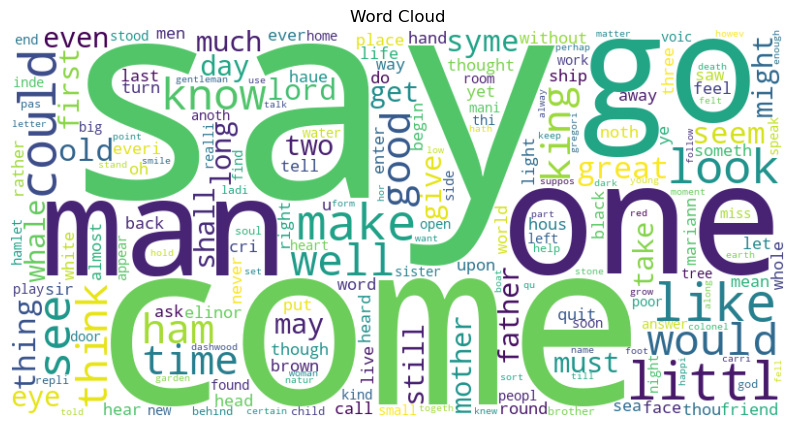


Subset of results:
Book       True Author                    Predicted Book                 Predicted Author              
d          Sara Cone Bryant               d                              Sara Cone Bryant              
f          Jane Austen                    f                              Jane Austen                   
a          G. K. Chesterton               a                              G. K. Chesterton              
e          William Shakespeare            e                              Dick by Herman Melville       
c          Dick by Herman Melville        c                              Dick by Herman Melville       
c          Dick by Herman Melville        c                              Dick by Herman Melville       
b          G. K. Chesterton               b                              G. K. Chesterton              
d          Sara Cone Bryant               d                              Sara Cone Bryant              
e          William Shakespeare            e 

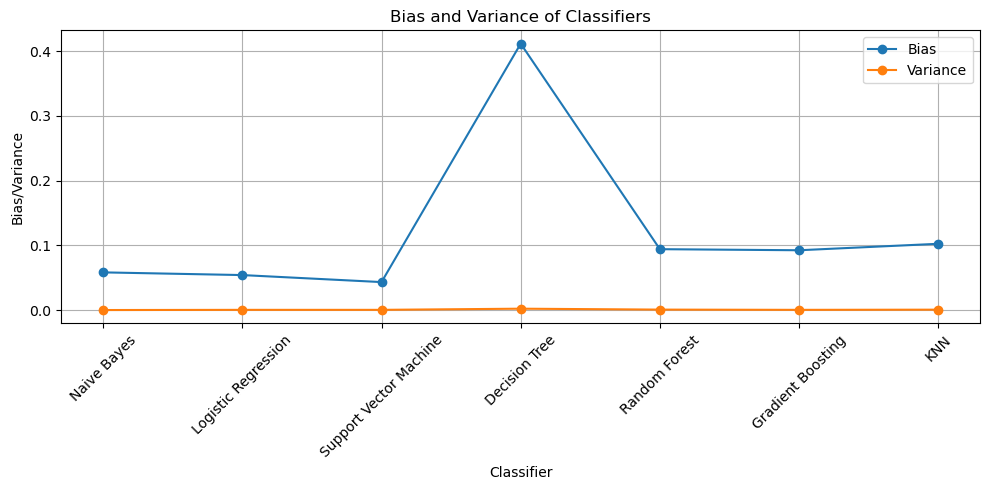

In [15]:
def main():
    classifiers = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Support Vector Machine': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'KNN': KNeighborsClassifier(),  # Add KNN Classifier
    }

    results = {}

    for name, classifier in classifiers.items():
        print(f"Evaluating {name}...")
        vectorizer = TfidfVectorizer(max_features=1000)
        trained_classifier, trained_vectorizer, authors = train_model(classifier, vectorizer)
        evaluation_results = evaluate_model(trained_classifier, trained_vectorizer, authors)
        results[name] = evaluation_results
        print(f"Results for {name}:")
        for metric, value in evaluation_results.items():
            print(f"{metric}: {value}")

        df = pd.read_csv('random_partitions.csv')
        df['Processed_Partition'] = df['Partition'].apply(preprocess_text)
        test_features = trained_vectorizer.transform(df['Processed_Partition']).toarray()
        test_labels = df['Book']
        predictions = trained_classifier.predict(test_features)

        # visualize_results(test_labels, predictions)

        # Tokenize the words
        df['tokenized_text'] = df['Processed_Partition'].apply(word_tokenize)

        # Flatten the list of lists
        all_words = [word for sublist in df['tokenized_text'] for word in sublist]

        # Create a Counter to get word frequencies
        word_freq = Counter(all_words)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Plot the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud')
        plt.show()
        #plt.hist(features)

        # Print subset of results
        start_idx = 10
        end_idx = 30
        print_results_subset(df, test_labels, predictions, authors, start_idx, end_idx)

    plot_bias_variance(classifiers, results)

if __name__ == "__main__":
    main()